In [1]:
import sys
import os
import numpy as np

def load_dataset():
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [2]:
from wrapper import Network
import lasagne

layers = [
            dict(type='InputLayer', shape=(None, 1, 28, 28)),
            dict(type='Conv2DLayer', num_filters=128, filter_size=3),
            dict(type='Pool2DLayer', pool_size=2),
            dict(type='Conv2DLayer', num_filters=256, filter_size=3),
            dict(type='Pool2DLayer', pool_size=2),
            dict(type='DenseLayer', num_units=100),
            dict(type='DenseLayer', num_units=10, nonlinearity=lasagne.nonlinearities.softmax),
]

net = Network(layers).compiled()

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


In [3]:
for _ in range(10):
    net.iterate__train(X_train, y_train, 300)

Loss: 0.2201: 166it [00:07, 23.69it/s]
Loss: 0.1590: 166it [00:07, 21.87it/s]
Loss: 0.0930: 166it [00:07, 23.47it/s]
Loss: 0.0896: 166it [00:07, 22.86it/s]
Loss: 0.0285: 166it [00:07, 22.20it/s]
Loss: 0.0315: 166it [00:07, 22.08it/s]
Loss: 0.0422: 166it [00:07, 22.61it/s]
Loss: 0.0267: 166it [00:07, 23.28it/s]
Loss: 0.0523: 166it [00:07, 21.44it/s]
Loss: 0.0191: 166it [00:07, 19.68it/s]


In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

5


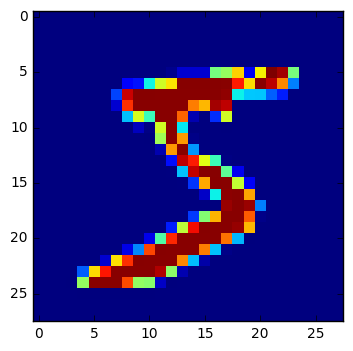

In [5]:
print(np.argmax(net.predict([X_train[0]])))
plt.imshow(X_train[0, 0], interpolation='none')

In [47]:
from tqdm import tqdm
import numpy as np

def generate_pathces(x, shape, count_per_entry):
#     per_entry = (count - 1) // len(x) + 1
    for y in x:
        upper = np.array(y.shape) - shape + 1
        for _ in range(count_per_entry):
#             if count <= 0:
#                 return
            begin = [np.random.randint(0, i) for i in upper]
            end = begin + np.array(shape)
            idx = [slice(*i) for i in zip(begin, end)]
            yield y[idx]
#             count -= 1

def sampler(x, shape, inner_shape, count):
    begin = (np.array(shape) - inner_shape) // 2
    end = begin + inner_shape
    coords = [slice(*i) for i in zip(begin, end)]
    
    A = b = n = 0
    negation = None
    for y in generate_pathces(x, shape, count):
        p1 = y[coords]

        if negation is None:
            negation = np.ones(y.shape, dtype=bool)
            negation[coords] = False

        p2 = y[negation]
        y = np.hstack((p1.reshape(-1), p2.reshape(-1)))

        A += np.tensordot(y, y, axes=0)
        b += y
        n += 1

    b /= n
    A = A / (n - 1) - n / (n - 1) * np.tensordot(b, b, axes=0)
    
    size = np.prod(inner_shape)
    S_11 = A[:size, :size]
    S_12 = A[:size, size:]
    S_22 = A[size:, size:]
    prod = S_12.dot(np.linalg.inv(S_22))
    mu = b[:size] - prod.dot(b[size:])
    S = S_11 - prod.dot(S_12.T)
    
    def wrapped(a, size):
        a = a[negation].reshape(-1)
        ret = np.random.multivariate_normal(mu + prod.dot(a), S, size)
        return ret.reshape((size,) + inner_shape)
    return wrapped

def odds(x):
    return x / (1 - x)

def get_saliency(network, source, outer_shape, inner_shape, batch_size, sample, num_samples, step=1, verbose=False):
    begin = (np.array(outer_shape) - inner_shape) // 2
    end = begin + inner_shape
    coords = [slice(*i) for i in zip(begin, end)]
    
    dims = np.array(source.shape) - outer_shape + 1
    dims = dims // step
    dims[dims == 0] = 1
    
    probs = np.zeros(dims)
    real = network([source])[0]

    batch = []
    indexes = []
    
    # calculate the probabilities
    bar = np.ndindex(*dims)
    if verbose:
        bar = tqdm(bar)
    for corner in bar:
        real_corner = np.array(corner) * step
        start = real_corner + begin
        idx = [slice(*i) for i in zip(start, start + inner_shape)]
        surround = [slice(*i) for i in zip(real_corner, real_corner + outer_shape)]
        surround = source[surround]

        for s in sample(surround, num_samples):
            temp = source.copy()
            temp[idx] = s
            batch.append(temp)
            indexes.append(corner)
            if len(batch) == batch_size:
                prob = network(batch)
                for key, value in zip(indexes, prob):
                    probs[key] += value
                batch = []
                indexes = []
                
    if batch:
        prob = network(batch)
        for key, value in zip(indexes, prob):
            probs[key] += value
    probs /= num_samples
     
    # create the attention map
    probs = np.log(odds(probs))
    real = np.log(odds(real))
    saliency = np.zeros_like(source)
    counts = np.zeros_like(source)
    
    for corner in np.ndindex(*dims):
        real_corner = np.array(corner) * step
        start = real_corner + begin
        idx = [slice(*i) for i in zip(start, start + inner_shape)]

        saliency[idx] += real - probs[corner]
        counts[idx] += 1
        
    counts[counts == 0] = 1    
    return saliency / counts / np.log(2)

In [43]:
X_train.shape

(50000, 1, 28, 28)

In [18]:
outer_shape, inner_shape = (1, 10, 10), (1, 6, 6)
sample = sampler(X_train, outer_shape, inner_shape, 10)

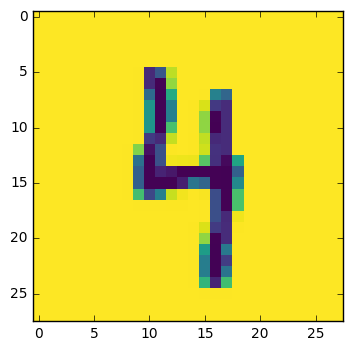

In [44]:
source = X_train[1110]
plt.imshow(source[0], interpolation='none', cmap='viridis_r')

In [45]:
def network(x):
    p = net.predict(x)[:, 4]
#     laplace correction
    return  (p * len(X_train) + 1) / (len(X_train) + 10)

In [53]:
ss = get_saliency(network, source, outer_shape, inner_shape, 100,  sample, 10, step=1, verbose=True)



0it [00:00, ?it/s]

62it [00:00, 611.92it/s]

123it [00:00, 608.20it/s]

220it [00:00, 684.12it/s]

335it [00:00, 778.54it/s]

361it [00:00, 844.50it/s]

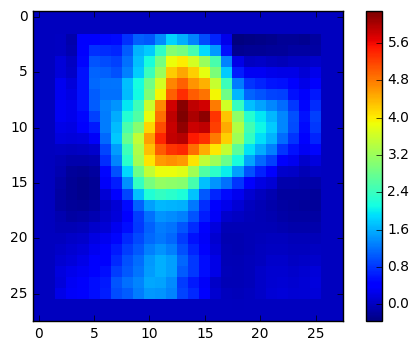

In [49]:
plt.imshow(ss[0], interpolation='none')
plt.colorbar()